# 🎬 모델 2: 동적 수익 곡선 예측 엔진 (Rb & Ra)

## 📋 개요

이 노트북은 한국 영화 시장의 **동적 홀드백 최적화** 연구를 위한 **모델 2 (수익 곡선 예측 엔진)**을 구축합니다.

### 🎯 목표

- **모델 2-A**: LSTM으로 Rb(자연 수익 곡선) 예측
- **모델 2-B**: Rule-Based로 Ra(잠식 수익 곡선) 시뮬레이션
- **통합 파이프라인**: Part 3 시뮬레이션용 API 제공

### 🔑 핵심 공식

```
Rb(t) = LSTM(과거 7일 피처) → 8일째 매출 예측
C = BaseRate × (1 + ONS) × (1 - TFS) × γ
Ra(t) = Rb(t) × (1 - C)  (홀드백 이후)
```

### 📊 데이터 흐름

```
STEP 1: 데이터 로딩 (5개 데이터셋)
    ↓
STEP 2: Feature Engineering (6개 피처)
    ↓
STEP 3: 시계열 변환 (7일→8일 시퀀스)
    ↓
STEP 4: LSTM 모델 훈련 (Rb 예측)
    ↓
STEP 5: Ra 시뮬레이션 (Gamma 반영)
    ↓
STEP 6: 통합 파이프라인 (API)
    ↓
STEP 7: 모델 저장 및 검증
```

---


In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows)
import platform
import matplotlib.font_manager as fm

if platform.system() == 'Windows':
    # Windows의 경우 맑은 고딕 사용
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("✓ 한글 폰트 설정 완료")

✓ 한글 폰트 설정 완료


# 📊 STEP 1: 데이터 로딩 및 전처리

**목표**: 5개 데이터셋 로드 및 날짜 변환, 개봉일 기준 경과일 계산

**데이터셋**:
- `Daily_Performance.csv` - 일별 극장 성과
- `kobis.csv` - KOBIS Top 10 데이터
- `Online_Buzz_filtered_v1.csv` - 검색 지수
- `movie_metadata.csv` - 영화 메타데이터  
- `OTT_suitability_score.csv` - 장르별 TFS/ONS


In [182]:
# ============================================
# STEP 1: 데이터 로딩 및 전처리
# ============================================

print("=" * 60)
print("STEP 1: 데이터 로딩 시작")
print("=" * 60)

# 1.1 모든 데이터셋 로드
performance = pd.read_csv('CONF_ENT_6/Daily_Performance/Daily_Performance.csv')
kobis = pd.read_csv('CONF_ENT_6/kobis/kobis.csv')
online_buzz = pd.read_csv('CONF_ENT_6/Online_Buzz/Online_Buzz_filtered_v1.csv')
movie_meta = pd.read_csv('CONF_ENT_6/기준영화 데이터/movie_metadata.csv', encoding='utf-8')
ott_score = pd.read_csv('CONF_ENT_6/OTT_suitability_score/OTT_suitability_score.csv')

print(f"✓ Performance data: {performance.shape}")
print(f"✓ KOBIS data: {kobis.shape}")
print(f"✓ Online Buzz data: {online_buzz.shape}")
print(f"✓ Movie Metadata: {movie_meta.shape}")
print(f"✓ OTT Suitability Score: {ott_score.shape}")

performance.head()

STEP 1: 데이터 로딩 시작
✓ Performance data: (2188, 7)
✓ KOBIS data: (10040, 20)
✓ Online Buzz data: (28322, 4)
✓ Movie Metadata: (83, 29)
✓ OTT Suitability Score: (12, 13)


,performance_id,movie_id,performance_date,daily_audi_cnt,daily_sales_amt,screen_cnt,show_cnt
0,1,20190300,2024-12-31,97289,868502890,1029,1029
1,2,20190300,2025-01-01,93154,880276910,979,979
2,3,20190300,2025-01-02,25303,222931920,915,915
3,4,20190300,2025-01-03,21203,198105460,833,833
4,5,20190300,2025-01-04,45091,431379240,779,779


In [183]:
# 1.2 날짜 타입 변환
print("\n날짜 컬럼 변환 중...")

performance['performance_date'] = pd.to_datetime(performance['performance_date'])
kobis['targetDt'] = pd.to_datetime(kobis['targetDt'].astype(str), format='%Y%m%d')
kobis['openDt'] = pd.to_datetime(kobis['openDt'].astype(str), format='%Y%m%d', errors='coerce')
online_buzz['buzz_date'] = pd.to_datetime(online_buzz['buzz_date'])
movie_meta['openDt'] = pd.to_datetime(movie_meta['openDt'].astype(str), format='%Y%m%d', errors='coerce')

print("✓ 날짜 변환 완료")
print(f"\nPerformance 날짜 범위: {performance['performance_date'].min()} ~ {performance['performance_date'].max()}")
print(f"KOBIS 날짜 범위: {kobis['targetDt'].min()} ~ {kobis['targetDt'].max()}")



날짜 컬럼 변환 중...
✓ 날짜 변환 완료

Performance 날짜 범위: 2023-01-11 00:00:00 ~ 2025-02-11 00:00:00
KOBIS 날짜 범위: 2023-01-01 00:00:00 ~ 2025-09-30 00:00:00


In [184]:
# 1.3 영화별 개봉일 기준 경과일 계산
print("\n개봉일 정보 병합 및 경과일 계산...")

# movie_meta에서 movieCd를 문자열로 변환 (매칭 위해)
movie_meta['movieCd'] = movie_meta['movieCd'].astype(str)
performance['movie_id'] = performance['movie_id'].astype(str)

# 개봉일 및 장르 정보 병합
performance = performance.merge(
    movie_meta[['movieCd', 'openDt', 'genre']], 
    left_on='movie_id', 
    right_on='movieCd', 
    how='left'
)

# 개봉 후 경과일 계산
performance['day_number'] = (performance['performance_date'] - performance['openDt']).dt.days + 1

# 결측치 제거 (개봉일 정보가 없는 경우)
performance = performance.dropna(subset=['openDt', 'day_number'])
performance = performance[performance['day_number'] > 0]  # 개봉일 이전 데이터 제거

print(f"✓ 병합 완료. 최종 데이터: {performance.shape}")
print(f"✓ 총 영화 수: {performance['movie_id'].nunique()}")
print(f"\n샘플 데이터:")
performance[['movie_id', 'performance_date', 'openDt', 'day_number', 'daily_sales_amt']].head()



개봉일 정보 병합 및 경과일 계산...
✓ 병합 완료. 최종 데이터: (2000, 11)
✓ 총 영화 수: 77

샘플 데이터:


,movie_id,performance_date,openDt,day_number,daily_sales_amt
0,20190300,2024-12-31,2024-12-31,1,868502890
1,20190300,2025-01-01,2024-12-31,2,880276910
2,20190300,2025-01-02,2024-12-31,3,222931920
3,20190300,2025-01-03,2024-12-31,4,198105460
4,20190300,2025-01-04,2024-12-31,5,431379240


# 🔧 STEP 2: Feature Engineering

**목표**: LSTM 모델 입력을 위한 6개 핵심 피처 생성

**생성 피처**:
1. `day_number` - 개봉 후 경과일
2. `is_weekend` - 주말 여부
3. `screen_cnt` - 스크린 수
4. `aud_per_show` - 회당 관객 수 (좌석 점유율 대리)
5. `competition_index` - HHI 경쟁 강도 (CI', α 대리)
6. `social_buzz` - 검색 지수 (WOM)


In [185]:
# ============================================
# STEP 2: Feature Engineering
# ============================================

print("\n" + "=" * 60)
print("STEP 2: Feature Engineering 시작")
print("=" * 60)

# 2.1 시간 변수
print("\n[2.1] 시간 변수 생성...")
performance['is_weekend'] = performance['performance_date'].dt.dayofweek.isin([5, 6]).astype(int)
print(f"✓ is_weekend 생성 완료 (주말 비율: {performance['is_weekend'].mean():.2%})")

# 2.2 KOBIS 성과 변수
print("\n[2.2] 회당 관객 수 계산...")
performance['aud_per_show'] = performance['daily_audi_cnt'] / performance['show_cnt']
performance['aud_per_show'] = performance['aud_per_show'].replace([np.inf, -np.inf], np.nan).fillna(0)
print(f"✓ aud_per_show 계산 완료 (평균: {performance['aud_per_show'].mean():.2f}명/회)")

print("\nFeature Engineering 진행 상황:")
print(f"- 현재 데이터 shape: {performance.shape}")
print(f"- 새로 생성된 변수: day_number, is_weekend, aud_per_show")



STEP 2: Feature Engineering 시작

[2.1] 시간 변수 생성...
✓ is_weekend 생성 완료 (주말 비율: 27.55%)

[2.2] 회당 관객 수 계산...
✓ aud_per_show 계산 완료 (평균: 47.51명/회)

Feature Engineering 진행 상황:
- 현재 데이터 shape: (2000, 13)
- 새로 생성된 변수: day_number, is_weekend, aud_per_show


In [186]:
# 2.3 경쟁 강도 변수 (HHI Screen Share - CI')
print("\n[2.3] 경쟁 강도 지수(CI') 계산 중...")
print("이 작업은 시간이 걸릴 수 있습니다...")

def calculate_daily_competition_index(kobis_df):
    """
    각 날짜별, 각 영화별 경쟁 강도 지수를 계산
    CI'(d, i) = Σ(Share_j^2) for j ≠ i (해당 영화를 제외한 다른 영화들의 점유율 제곱합)
    """
    result = []
    
    # movieCd를 문자열로 변환
    kobis_df = kobis_df.copy()
    kobis_df['movieCd'] = kobis_df['movieCd'].astype(str)
    
    # 날짜별로 그룹화
    for date in kobis_df['targetDt'].unique():
        daily_data = kobis_df[kobis_df['targetDt'] == date].copy()
        total_screens = daily_data['scrnCnt'].sum()
        
        if total_screens == 0:
            continue
        
        # 각 영화별로 CI' 계산
        for idx, row in daily_data.iterrows():
            movie_id = row['movieCd']
            
            # 해당 영화를 제외한 다른 영화들의 점유율 제곱합
            other_movies = daily_data[daily_data['movieCd'] != movie_id]
            shares = other_movies['scrnCnt'] / total_screens
            ci_prime = (shares ** 2).sum()
            
            result.append({
                'movieCd': movie_id,
                'targetDt': date,
                'competition_index': ci_prime
            })
    
    return pd.DataFrame(result)

# CI' 계산
competition_df = calculate_daily_competition_index(kobis)
print(f"✓ CI' 계산 완료: {len(competition_df)} 레코드 생성")

# Performance 데이터와 병합
performance = performance.merge(
    competition_df,
    left_on=['movie_id', 'performance_date'],
    right_on=['movieCd', 'targetDt'],
    how='left'
)

# 결측치 처리 (KOBIS Top 10에 없는 영화는 경쟁 강도를 0으로 설정)
performance['competition_index'] = performance['competition_index'].fillna(0)

print(f"✓ CI' 병합 완료")
print(f"  - CI' 평균: {performance['competition_index'].mean():.4f}")
print(f"  - CI' 범위: {performance['competition_index'].min():.4f} ~ {performance['competition_index'].max():.4f}")



[2.3] 경쟁 강도 지수(CI') 계산 중...
이 작업은 시간이 걸릴 수 있습니다...
✓ CI' 계산 완료: 10040 레코드 생성
✓ CI' 병합 완료
  - CI' 평균: 0.1352
  - CI' 범위: 0.0280 ~ 0.4097


In [187]:
# 2.4 WOM (Word of Mouth) 변수
print("\n[2.4] WOM(검색 지수) 데이터 병합...")

# movieCd 타입 통일
online_buzz['movieCd'] = online_buzz['movieCd'].astype(str)

# Online Buzz 병합
performance = performance.merge(
    online_buzz[['movieCd', 'buzz_date', 'search_buzz_vol']].rename(columns={'buzz_date': 'performance_date', 'search_buzz_vol': 'social_buzz'}),
    left_on=['movie_id', 'performance_date'],
    right_on=['movieCd', 'performance_date'],
    how='left',
    suffixes=('', '_buzz')
)

# 결측치 처리 (검색 데이터가 없는 경우 0으로 설정)
performance['social_buzz'] = performance['social_buzz'].fillna(0)

print(f"✓ WOM 병합 완료")
print(f"  - social_buzz 평균: {performance['social_buzz'].mean():.2f}")
print(f"  - social_buzz > 0 비율: {(performance['social_buzz'] > 0).mean():.2%}")

# 중복 컬럼 정리
if 'movieCd_buzz' in performance.columns:
    performance = performance.drop(columns=['movieCd_buzz'])

print("\n" + "=" * 60)
print("STEP 2 완료: Feature Engineering")
print("=" * 60)
print(f"최종 Feature 리스트:")
print("  1. day_number (개봉 후 경과일)")
print("  2. is_weekend (주말 여부)")
print("  3. screen_cnt (스크린 수)")
print("  4. aud_per_show (회당 관객 수)")
print("  5. competition_index (경쟁 강도 CI')")
print("  6. social_buzz (검색 지수)")
print(f"\n현재 데이터 shape: {performance.shape}")



[2.4] WOM(검색 지수) 데이터 병합...
✓ WOM 병합 완료
  - social_buzz 평균: 33.84
  - social_buzz > 0 비율: 96.25%

STEP 2 완료: Feature Engineering
최종 Feature 리스트:
  1. day_number (개봉 후 경과일)
  2. is_weekend (주말 여부)
  3. screen_cnt (스크린 수)
  4. aud_per_show (회당 관객 수)
  5. competition_index (경쟁 강도 CI')
  6. social_buzz (검색 지수)

현재 데이터 shape: (2000, 18)


# 🔄 STEP 3: 시계열 데이터 변환 (LSTM 입력용)

**목표**: 7일 시퀀스 → 8일째 매출 예측 데이터셋 생성

**프로세스**:
1. 피처 선택 및 결측치 처리
2. StandardScaler 정규화
3. 슬라이딩 윈도우로 시퀀스 생성
   - 입력: `(샘플 수, 7일, 6 피처)`
   - 출력: `(샘플 수, 1)` - 8일째 매출액


In [188]:
# ============================================
# STEP 3: 시계열 데이터 변환 (LSTM 입력용)
# ============================================

from sklearn.preprocessing import StandardScaler

print("\n" + "=" * 60)
print("STEP 3: 시계열 데이터 변환 시작")
print("=" * 60)

# 3.1 피처 선택
feature_cols = [
    'day_number',           # 개봉 후 경과일
    'is_weekend',           # 주말 여부
    'screen_cnt',           # 스크린 수
    'aud_per_show',         # 회당 관객 수
    'competition_index',    # 경쟁 강도 (CI')
    'social_buzz'           # 검색 지수
]

target_col = 'daily_sales_amt'

print(f"\n[3.1] 피처 선택 완료:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i}. {feat}")

# 결측치 처리
print(f"\n[3.2] 결측치 처리...")
print(f"  - 처리 전 결측치: {performance[feature_cols].isnull().sum().sum()}")
performance[feature_cols] = performance[feature_cols].fillna(0)
performance[target_col] = performance[target_col].fillna(0)
print(f"  - 처리 후 결측치: {performance[feature_cols].isnull().sum().sum()}")

# 음수/이상치 처리
performance[target_col] = performance[target_col].clip(lower=0)

print(f"\n데이터 통계:")
print(performance[feature_cols + [target_col]].describe())



STEP 3: 시계열 데이터 변환 시작

[3.1] 피처 선택 완료:
  1. day_number
  2. is_weekend
  3. screen_cnt
  4. aud_per_show
  5. competition_index
  6. social_buzz

[3.2] 결측치 처리...
  - 처리 전 결측치: 0
  - 처리 후 결측치: 0

데이터 통계:
        day_number   is_weekend   screen_cnt  aud_per_show  competition_index  \
count  2000.000000  2000.000000  2000.000000   2000.000000        2000.000000   
mean     20.961500     0.275500   803.585000     47.505822           0.135211   
std      23.264407     0.446878   518.557421     54.659827           0.048482   
min       1.000000     0.000000     4.000000      4.731884           0.027987   
25%       7.750000     0.000000   480.750000     15.806156           0.106416   
50%      16.000000     0.000000   715.500000     28.693093           0.126175   
75%      29.000000     1.000000   998.000000     56.596693           0.156918   
max     447.000000     1.000000  2980.000000    450.257165           0.409736   

       social_buzz  daily_sales_amt  
count  2000.000000     2.000

In [189]:
# 3.3 정규화 (Scaling)
print(f"\n[3.3] 데이터 정규화 (StandardScaler)...")

# 복사본 생성 (원본 보존)
performance_scaled = performance.copy()

# X 정규화
scaler_X = StandardScaler()
performance_scaled[feature_cols] = scaler_X.fit_transform(performance_scaled[feature_cols])

# y 정규화
scaler_y = StandardScaler()
performance_scaled['daily_sales_amt_scaled'] = scaler_y.fit_transform(performance_scaled[[target_col]])

print(f"✓ 정규화 완료")
print(f"  - scaler_X mean: {scaler_X.mean_[:3]}...")
print(f"  - scaler_y mean: {scaler_y.mean_[0]:,.0f} KRW")
print(f"  - scaler_y std: {scaler_y.scale_[0]:,.0f} KRW")



[3.3] 데이터 정규화 (StandardScaler)...
✓ 정규화 완료
  - scaler_X mean: [2.09615e+01 2.75500e-01 8.03585e+02]...
  - scaler_y mean: 565,564,758 KRW
  - scaler_y std: 1,182,042,283 KRW


In [190]:
# 3.4 시퀀스 생성 함수
print(f"\n[3.4] 시퀀스 생성 함수 정의...")

def create_sequences(df, movie_id_col, date_col, feature_cols, target_col, seq_length=7):
    """
    영화별로 시계열 시퀀스 생성
    X: (샘플 수, seq_length, 피처 개수)
    y: (샘플 수, 1)
    """
    X_list, y_list = [], []
    movie_ids_list = []  # 디버깅용
    
    # 영화별로 그룹화
    unique_movies = df[movie_id_col].unique()
    
    for movie_id in unique_movies:
        movie_df = df[df[movie_id_col] == movie_id].sort_values(date_col).reset_index(drop=True)
        
        # 최소한 seq_length + 1일 이상의 데이터가 있어야 함
        if len(movie_df) < seq_length + 1:
            continue
        
        # 슬라이딩 윈도우로 시퀀스 생성
        for i in range(len(movie_df) - seq_length):
            X_seq = movie_df.loc[i:i+seq_length-1, feature_cols].values
            y_val = movie_df.loc[i+seq_length, target_col]
            
            X_list.append(X_seq)
            y_list.append(y_val)
            movie_ids_list.append(movie_id)
    
    return np.array(X_list), np.array(y_list), movie_ids_list

print(f"✓ 시퀀스 생성 함수 정의 완료")
print(f"  - 입력: 과거 7일간의 피처")
print(f"  - 출력: 8일째 매출액")
print(f"  - 방법: 슬라이딩 윈도우")



[3.4] 시퀀스 생성 함수 정의...
✓ 시퀀스 생성 함수 정의 완료
  - 입력: 과거 7일간의 피처
  - 출력: 8일째 매출액
  - 방법: 슬라이딩 윈도우


# 🧠 STEP 4: LSTM 모델 구축 및 훈련

**목표**: Rb(자연 수익 곡선) 예측을 위한 Stacked LSTM 모델 학습

**모델 아키텍처**:
```
LSTM(64, return_sequences=True)
→ Dropout(0.2)
→ LSTM(32)
→ Dropout(0.2)
→ Dense(16, relu)
→ Dense(1)
```

**평가 지표**: MAE, RMSE, R²


In [191]:
# 3.5 시퀀스 생성 실행
print(f"\n[3.5] 시퀀스 생성 중...")
print("이 작업은 시간이 걸릴 수 있습니다...")

X_train, y_train, movie_ids = create_sequences(
    df=performance_scaled,
    movie_id_col='movie_id',
    date_col='performance_date',
    feature_cols=feature_cols,
    target_col='daily_sales_amt_scaled',
    seq_length=7
)

print(f"\n✓ 시퀀스 생성 완료!")
print(f"  - X_train shape: {X_train.shape} (샘플 수, 시퀀스 길이, 피처 수)")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - 총 샘플 수: {len(X_train):,}")
print(f"  - 사용된 영화 수: {len(set(movie_ids))}")

print("\n" + "=" * 60)
print("STEP 3 완료: 시계열 데이터 변환")
print("=" * 60)



[3.5] 시퀀스 생성 중...
이 작업은 시간이 걸릴 수 있습니다...



✓ 시퀀스 생성 완료!
  - X_train shape: (1499, 7, 6) (샘플 수, 시퀀스 길이, 피처 수)
  - y_train shape: (1499,)
  - 총 샘플 수: 1,499
  - 사용된 영화 수: 61

STEP 3 완료: 시계열 데이터 변환


In [192]:
# ============================================
# STEP 4: LSTM 모델 구축 및 훈련
# ============================================

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("\n" + "=" * 60)
print("STEP 4: LSTM 모델 구축 및 훈련 시작")
print("=" * 60)

# 4.1 Train/Validation Split
print(f"\n[4.1] Train/Validation Split (80/20)...")

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"✓ Split 완료")
print(f"  - Train: {X_train_split.shape[0]:,} 샘플")
print(f"  - Validation: {X_val_split.shape[0]:,} 샘플")



STEP 4: LSTM 모델 구축 및 훈련 시작

[4.1] Train/Validation Split (80/20)...
✓ Split 완료
  - Train: 1,199 샘플
  - Validation: 300 샘플


In [193]:
# 4.2 Stacked LSTM 모델 정의
print(f"\n[4.2] Stacked LSTM 모델 아키텍처 구축...")

model_Rb = Sequential([
    LSTM(64, return_sequences=True, input_shape=(7, len(feature_cols))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # 매출액 예측
])

model_Rb.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"✓ 모델 구축 완료")
print(f"\n모델 아키텍처:")
model_Rb.summary()



[4.2] Stacked LSTM 모델 아키텍처 구축...
✓ 모델 구축 완료

모델 아키텍처:


c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 7, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
# 4.3 모델 학습
print(f"\n[4.3] 모델 학습 시작...")
print("=" * 60)
print("학습 시간이 오래 걸릴 수 있습니다 (약 5-10분)")
print("=" * 60)

# Callbacks 설정
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'model_Rb_best.h5', 
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

# 학습 실행
history = model_Rb.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print(f"\n✓ 학습 완료!")
print(f"  - 최종 Train Loss: {history.history['loss'][-1]:.6f}")
print(f"  - 최종 Val Loss: {history.history['val_loss'][-1]:.6f}")
print(f"  - 학습 Epoch: {len(history.history['loss'])}")



[4.3] 모델 학습 시작...
학습 시간이 오래 걸릴 수 있습니다 (약 5-10분)
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4251 - mae: 0.3659
Epoch 1: val_loss improved from None to 0.11753, saving model to model_Rb_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.3542 - mae: 0.3090 - val_loss: 0.1175 - val_mae: 0.1838
Epoch 2/100
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2938 - mae: 0.2490
Epoch 2: val_loss improved from 0.11753 to 0.11244, saving model to model_Rb_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2274 - mae: 0.2147 - val_loss: 0.1124 - val_mae: 0.1558
Epoch 3/100
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2553 - mae: 0.2246
Epoch 3: val_loss improved from 0.11244 to 0.07725, saving model to model_Rb_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2159 - mae: 0.2054 - val_loss: 0.0773 - val_mae: 0.1248
Epoch 4/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1755 - mae: 0.1753
Epoch 4: val_loss did not improve from 0.07725
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1834 - mae: 0.1861 - val_loss: 0.1278 - val_mae: 0.1473
Epoch 5/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1410 - mae: 0.1680
Epoch 5: val_loss did not improve from 0.07725
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1685 - mae: 0.1765 - val_loss: 0.0889 - val_mae: 0.1219
Epoch 6/100
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1137 - mae: 0.1565
Epoch 6: val_loss improved from 0.07725 to 0.05626, saving model to model_Rb_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1475 - mae: 0.1651 - val_loss: 0.0563 - val_mae: 0.1050
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1452 - mae: 0.1623
Epoch 7: val_loss did not improve from 0.05626
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1372 - mae: 0.1612 - val_loss: 0.1136 - val_mae: 0.1418
Epoch 8/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1264 - mae: 0.1699
Epoch 8: val_loss did not improve from 0.05626
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1295 - mae: 0.1612 - val_loss: 0.1853 - val_mae: 0.1500
Epoch 9/100
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1712 - mae: 0.1685
Epoch 9: val_loss did not improve from 0.05626
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1363 - mae: 0.1576 - val_loss: 0.0781 - val_mae: 0.1197
Epoch 10/100
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1436 - mae: 0.1587
Epoch 10: val_loss did not improve from 0.05626
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1111 - mae: 

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1018 - mae: 0.1383 - val_loss: 0.0518 - val_mae: 0.1052
Epoch 13/100
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1673 - mae: 0.1613
Epoch 13: val_loss did not improve from 0.05185
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1485 - mae: 0.1618 - val_loss: 0.0556 - val_mae: 0.1058
Epoch 14/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1193 - mae: 0.1470
Epoch 14: val_loss did not improve from 0.05185
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1090 - mae: 0.1416 - val_loss: 0.0684 - val_mae: 0.1101
Epoch 15/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0791 - mae: 0.1242
Epoch 15: val_loss improved from 0.05185 to 0.04534, saving model to model_Rb_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0948 - mae: 0.1336 - val_loss: 0.0453 - val_mae: 0.0962
Epoch 16/100
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0838 - mae: 0.1273
Epoch 16: val_loss did not improve from 0.04534
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0882 - mae: 0.1252 - val_loss: 0.0621 - val_mae: 0.1040
Epoch 17/100
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0946 - mae: 0.1297
Epoch 17: val_loss did not improve from 0.04534
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1008 - mae: 0.1318 - val_loss: 0.1178 - val_mae: 0.1258
Epoch 18/100
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0782 - mae: 0.1175
Epoch 18: val_loss did not improve from 0.04534
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0866 - mae: 0.1279 - val_loss: 0.1092 - val_mae: 0.1267
Epoch 19/100
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0744 - mae: 0.1284
Epoch 19: val_loss improved from 0.04534 to 0.04021, saving model to model_Rb_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0999 - mae: 0.1309 - val_loss: 0.0402 - val_mae: 0.0930
Epoch 20/100
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0766 - mae: 0.1173
Epoch 20: val_loss did not improve from 0.04021
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1072 - mae: 0.1368 - val_loss: 0.0873 - val_mae: 0.1143
Epoch 21/100
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0926 - mae: 0.1245
Epoch 21: val_loss did not improve from 0.04021
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0960 - mae: 0.1303 - val_loss: 0.0473 - val_mae: 0.0974
Epoch 22/100
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1214 - mae: 0.1354
Epoch 22: val_loss did not improve from 0.04021
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0857 - mae: 0.1194 - val_loss: 0.0621 - val_mae: 0.1038
Epoch 23/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0790 - mae: 0.1296
Epoch 23: val_loss did not improve from 0.04021
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0763 - ma

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1455 - mae: 0.1468 - val_loss: 0.0373 - val_mae: 0.1025
Epoch 25/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1016 - mae: 0.1425
Epoch 25: val_loss did not improve from 0.03731
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0838 - mae: 0.1294 - val_loss: 0.0480 - val_mae: 0.0953
Epoch 26/100
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0844 - mae: 0.1204
Epoch 26: val_loss did not improve from 0.03731
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0947 - mae: 0.1251 - val_loss: 0.0539 - val_mae: 0.1027
Epoch 27/100
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0815 - mae: 0.1186
Epoch 27: val_loss did not improve from 0.03731
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0794 - mae: 0.1177 - val_loss: 0.0618 - val_mae: 0.1045
Epoch 28/100
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0798 - mae: 0.1167
Epoch 28: val_loss did not improve from 0.03731
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0710 - 


[4.4] 학습 곡선 시각화...


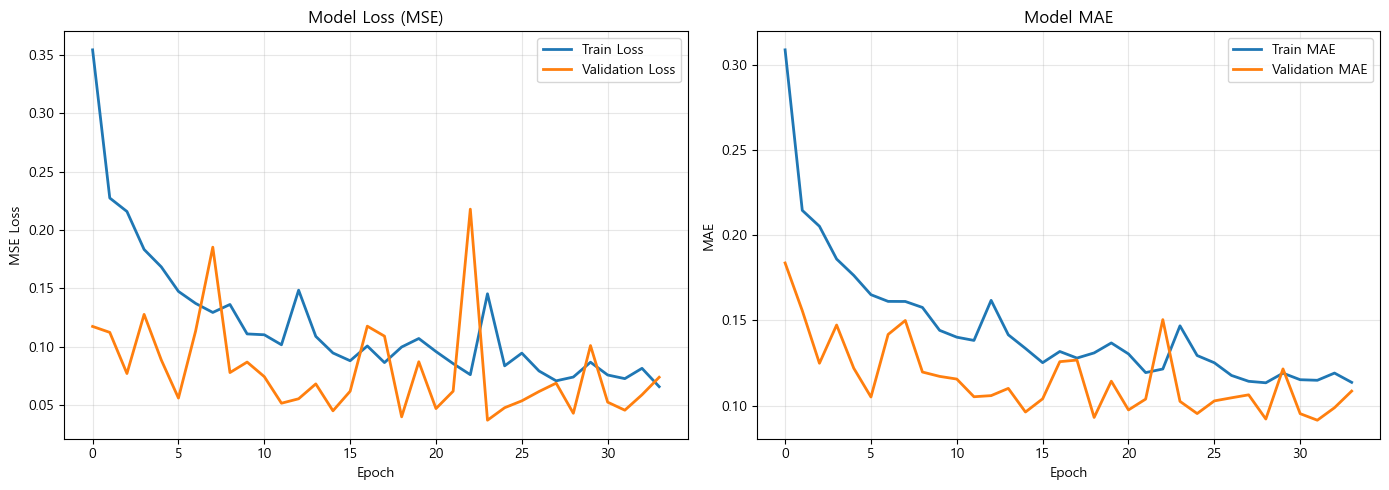

✓ 시각화 완료


In [195]:
# 4.4 학습 곡선 시각화
print(f"\n[4.4] 학습 곡선 시각화...")

plt.figure(figsize=(14, 5))

# Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Model Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)

# MAE 곡선
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ 시각화 완료")


# ⚙️ STEP 5: Ra 시뮬레이션 함수 구현

**목표**: Rule-Based 잠식 모델 구축 (OTT 출시 후 극장 수익 예측)

**핵심 공식**:
```
C = BaseRate × (1 + ONS) × (1 - TFS) × γ
Ra(t) = Rb(t) × (1 - C)  (홀드백 이후)
```

**단계**:
1. TFS/ONS 점수 병합 (장르별 극장/OTT 적합도)
2. Gamma(γ) 계산 (연도별 소비자 선호도)
3. 잠식 계수(C) 계산
4. Ra 시뮬레이션 함수 정의



[4.5] 모델 성능 평가...

📊 모델 2-A (Rb 예측 LSTM) 성능 평가 결과
  - MAE (평균 절대 오차):      121,103,993 KRW
  - RMSE (제곱근 평균 오차):     228,324,045 KRW
  - R² Score:                        0.8129


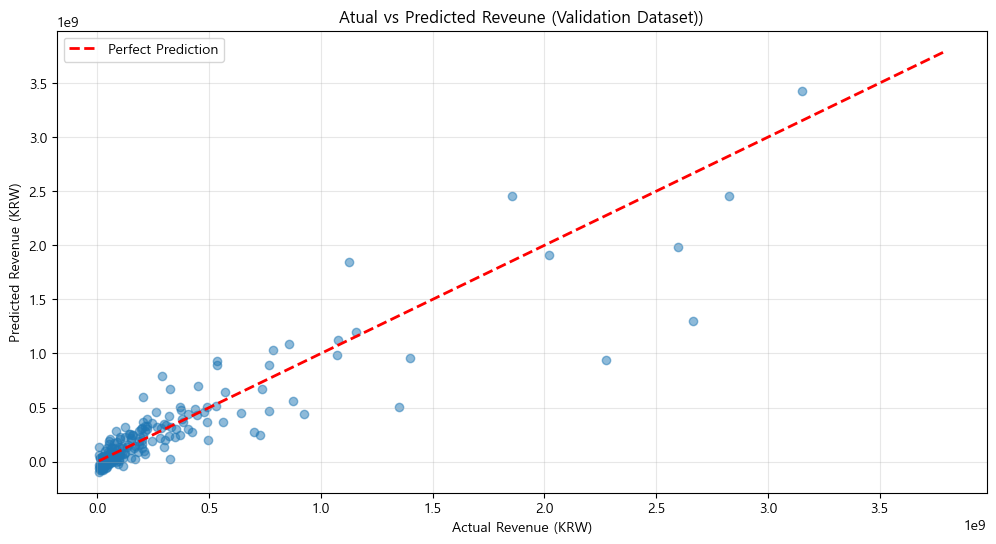


STEP 4 완료: LSTM 모델 구축 및 훈련


In [196]:
# 4.5 모델 평가
print(f"\n[4.5] 모델 성능 평가...")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 검증 데이터 예측
y_pred_scaled = model_Rb.predict(X_val_split, verbose=0)

# 역정규화 (실제 금액으로 변환)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_val_split.reshape(-1, 1))

# 평가 지표 계산
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\n{'='*60}")
print(f"📊 모델 2-A (Rb 예측 LSTM) 성능 평가 결과")
print(f"{'='*60}")
print(f"  - MAE (평균 절대 오차):  {mae:>15,.0f} KRW")
print(f"  - RMSE (제곱근 평균 오차): {rmse:>15,.0f} KRW")
print(f"  - R² Score:               {r2:>15.4f}")
print(f"{'='*60}")

# 예측 vs 실제 시각화
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(len(y_true), size=min(200, len(y_true)), replace=False)
plt.scatter(y_true[sample_indices], y_pred[sample_indices], alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Revenue (KRW)')
plt.ylabel('Predicted Revenue (KRW)')
plt.title('Atual vs Predicted Reveune (Validation Dataset))')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n" + "=" * 60)
print("STEP 4 완료: LSTM 모델 구축 및 훈련")
print("=" * 60)


In [197]:
# 5.1.5 Gamma(γ) 계산: 소비자 선호도 (OTT vs 극장)
print(f"\n[5.1.5] Gamma(γ) 소비자 선호도 계산...")

# Consumer Preference 데이터 로드 (encoding 문제 해결)
try:
    consumer_pref = pd.read_csv('CONF_ENT_6/Consumer_Pref/Consumer_Preference.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        consumer_pref = pd.read_csv('CONF_ENT_6/Consumer_Pref/Consumer_Preference.csv', encoding='euc-kr')
    except UnicodeDecodeError:
        consumer_pref = pd.read_csv('CONF_ENT_6/Consumer_Pref/Consumer_Preference.csv', encoding='cp949', errors='ignore')

# OTT 이용률 계산 (100 - OTT 비이용률)
consumer_pref['ott_usage_rate'] = 100 - consumer_pref['OTT 비이용']

# theater_visit_freq 처리 (">9.25" 같은 문자열 처리)
consumer_pref['theater_visit_freq'] = consumer_pref['theater_visit_freq'].replace('>9.25', 9.25)
consumer_pref['theater_visit_freq'] = pd.to_numeric(consumer_pref['theater_visit_freq'], errors='coerce')

# Gamma 계산 함수 (Step 1: Log 변환)
def calculate_gamma(ott_usage_rate, theater_visit_freq, epsilon=0.01):
    """
    소비자 선호도 Gamma 계산 (Log 변환)
    γ_log = Log(OTT 이용률 / (극장 방문 횟수 + ε))
    
    Parameters:
    - ott_usage_rate: OTT 이용률 (%)
    - theater_visit_freq: 연간 극장 방문 횟수
    - epsilon: 0 나눗셈 방지
    
    Returns:
    - gamma_log: Log 변환된 선호도 (음수 값)
    """
    return np.log((ott_usage_rate / 100) / (theater_visit_freq + epsilon))

# 연도별/연령대별 gamma 계산 (Log 값)
consumer_pref['gamma_log'] = consumer_pref.apply(
    lambda row: calculate_gamma(row['ott_usage_rate'], row['theater_visit_freq']),
    axis=1
)

print(f"✓ Gamma (Log) 계산 완료")
print(f"  - Gamma Log 평균: {consumer_pref['gamma_log'].mean():.3f}")
print(f"  - Gamma Log 범위: {consumer_pref['gamma_log'].min():.3f} ~ {consumer_pref['gamma_log'].max():.3f}")

# ⚠️ 중요: Min-Max Scaling으로 0~1 정규화
# Log 값이 음수이므로 exp() 변환 시 과소평가됨
# → Min-Max Scaling으로 0(극장 선호)~1(OTT 선호) 범위로 변환
print(f"\n[정규화] Min-Max Scaling 적용...")

gamma_min = consumer_pref['gamma_log'].min()
gamma_max = consumer_pref['gamma_log'].max()

consumer_pref['gamma'] = (consumer_pref['gamma_log'] - gamma_min) / (gamma_max - gamma_min)

print(f"✓ Gamma 정규화 완료")
print(f"  - Gamma (정규화) 평균: {consumer_pref['gamma'].mean():.3f}")
print(f"  - Gamma (정규화) 범위: {consumer_pref['gamma'].min():.3f} ~ {consumer_pref['gamma'].max():.3f}")
print(f"  - 해석: 0 = 극장 선호, 1 = OTT 선호")

print(f"\n연도별 평균 Gamma (정규화):")
yearly_gamma_stats = consumer_pref.groupby('연도')['gamma'].agg(['mean', 'min', 'max'])
for year, stats in yearly_gamma_stats.iterrows():
    print(f"  - {year}년: {stats['mean']:.3f} (범위: {stats['min']:.3f}~{stats['max']:.3f})")

print(f"\n연령대별 평균 Gamma (2024년 기준, 정규화):")
gamma_2024 = consumer_pref[consumer_pref['연도'] == 2024].groupby('age')['gamma'].mean().sort_values(ascending=False)
for age, gamma_val in gamma_2024.items():
    ott_pref_level = 'OTT 선호' if gamma_val > 0.6 else '중립' if gamma_val > 0.4 else '극장 선호'
    print(f"  - {age:15s}: {gamma_val:5.3f} ({ott_pref_level})")



[5.1.5] Gamma(γ) 소비자 선호도 계산...
✓ Gamma (Log) 계산 완료
  - Gamma Log 평균: -2.813
  - Gamma Log 범위: -3.902 ~ -2.586

[정규화] Min-Max Scaling 적용...
✓ Gamma 정규화 완료
  - Gamma (정규화) 평균: 0.827
  - Gamma (정규화) 범위: 0.000 ~ 1.000
  - 해석: 0 = 극장 선호, 1 = OTT 선호

연도별 평균 Gamma (정규화):
  - 2023년: 0.771 (범위: 0.000~1.000)
  - 2024년: 0.893 (범위: 0.831~0.991)

연령대별 평균 Gamma (2024년 기준, 정규화):
  - 40대            : 0.991 (OTT 선호)
  - 50대            : 0.947 (OTT 선호)
  - 13-19세         : 0.872 (OTT 선호)
  - 30대            : 0.860 (OTT 선호)
  - 20대            : 0.854 (OTT 선호)
  - 60대            : 0.831 (OTT 선호)
  - 70대 이상         :   nan (극장 선호)


In [198]:
# 5.1.6 영화별 Gamma 매핑
print(f"\n[5.1.6] 영화별 Gamma 매핑...")

# 연도별 평균 gamma 계산 (전체 연령대 평균)
yearly_gamma = consumer_pref.groupby('연도')['gamma'].mean().to_dict()

print(f"\n연도별 평균 Gamma:")
for year, gamma_val in yearly_gamma.items():
    print(f"  - {year}년: {gamma_val:.3f}")

# 영화 개봉 연도 추출
movie_meta['open_year'] = movie_meta['openDt'].dt.year

# 영화별 gamma 매핑 (개봉 연도 기준)
movie_meta['gamma'] = movie_meta['open_year'].map(yearly_gamma)

# 매핑되지 않은 경우 (2023, 2024 이외) 평균값 사용
default_gamma = consumer_pref['gamma'].mean()
movie_meta['gamma'] = movie_meta['gamma'].fillna(default_gamma)

print(f"\n✓ 영화별 Gamma 매핑 완료")
print(f"  - 매핑된 영화 수: {movie_meta['gamma'].notna().sum()}")
print(f"  - 기본값 사용 영화 수: {movie_meta['gamma'].isna().sum()}")
print(f"  - Gamma 평균: {movie_meta['gamma'].mean():.3f}")



[5.1.6] 영화별 Gamma 매핑...

연도별 평균 Gamma:
  - 2023년: 0.771
  - 2024년: 0.893

✓ 영화별 Gamma 매핑 완료
  - 매핑된 영화 수: 83
  - 기본값 사용 영화 수: 0
  - Gamma 평균: 0.831


In [199]:
# ============================================
# STEP 5: Ra 시뮬레이션 함수 구현
# ============================================

print("\n" + "=" * 60)
print("STEP 5: Ra 시뮬레이션 함수 구현 시작")
print("=" * 60)

# 5.1 장르별 TFS/ONS 병합
print(f"\n[5.1] 영화 메타데이터에 TFS/ONS 점수 병합...")

# 장르명 매핑 (한글 → 영문)
genre_mapping = {
    '액션': 'Action',
    '드라마': 'Drama',
    '코미디': 'Comedy',
    '스릴러': 'Thriller',
    '공포(호러)': 'Horror',
    '로맨스': 'Romance',
    'SF': 'Sci-Fi',
    '판타지': 'Fantasy',
    '다큐멘터리': 'Documentary',
    '애니메이션': 'Animation',
    '범죄': 'Thriller',  # 범죄는 스릴러로 매핑
    '모험': 'Action',     # 모험은 액션으로 매핑
}

# 장르 매핑 적용
movie_meta['genre_en'] = movie_meta['genre'].map(genre_mapping)

# 매핑되지 않은 장르는 Drama로 기본 설정
movie_meta['genre_en'] = movie_meta['genre_en'].fillna('Drama')

# TFS/ONS 점수 병합
movie_meta = movie_meta.merge(
    ott_score[['Genre', 'TFS', 'ONS']],
    left_on='genre_en',
    right_on='Genre',
    how='left'
)

print(f"✓ TFS/ONS 병합 완료")
print(f"  - TFS 평균: {movie_meta['TFS'].mean():.2f}")
print(f"  - ONS 평균: {movie_meta['ONS'].mean():.2f}")
print(f"\n장르별 TFS/ONS:")
print(movie_meta.groupby('genre_en')[['TFS', 'ONS']].mean().round(2))



STEP 5: Ra 시뮬레이션 함수 구현 시작

[5.1] 영화 메타데이터에 TFS/ONS 점수 병합...
✓ TFS/ONS 병합 완료
  - TFS 평균: 5.35
  - ONS 평균: 8.04

장르별 TFS/ONS:
             TFS  ONS
genre_en             
Action       8.4  4.2
Animation    8.7  6.8
Comedy       4.4  5.8
Documentary  2.7  7.4
Drama        4.7  9.4
Fantasy      8.3  8.4
Horror       7.2  6.8
Sci-Fi       9.0  7.4
Thriller     4.9  9.6


In [200]:
# 5.2 잠식 계수 계산 함수
print(f"\n[5.2] 잠식 계수 계산 함수 정의...")

def calculate_cannibalization_coefficient(tfs, ons, gamma=0.5, base_rate=0.3):
    """
    잠식 계수 C 계산 (readme_gammafunc_norms.md 기준)
    C = BaseRate × (1 + ONS_norm) × (1 - TFS_norm) × γ_norm
    
    Parameters:
    - tfs: Theatrical-First Score (0~10 범위)
    - ons: OTT-Native Score (0~10 범위)
    - gamma: 소비자 선호도 (정규화된 값, 0~1 범위)
      * 0: 극장 선호 (잠식 최소)
      * 1: OTT 선호 (잠식 최대)
      * ⚠️ 이미 Min-Max Scaling 적용됨 (Log 값 아님!)
    - base_rate: 기본 잠식률 (기본값 0.3 = 30%)
      * Conservative: 0.15 (15%)
      * Neutral: 0.30 (30%)
      * Aggressive: 0.50 (50%)
    
    Returns:
    - C: 잠식 계수 (0~1 사이로 클리핑)
    
    ⚠️ 주의:
    - gamma는 이미 0~1 범위로 정규화되어 있으므로 exp() 변환 불필요
    - gamma가 클수록 잠식률이 증가 (OTT 선호 → 극장 수요 감소)
    """
    # TFS/ONS 정규화 (0~10 → 0~1)
    tfs_norm = tfs / 10.0
    ons_norm = ons / 10.0
    
    # Gamma는 이미 정규화됨 (0~1)
    # 0 = 극장 선호 → 잠식률 낮음
    # 1 = OTT 선호 → 잠식률 높음
    # 따라서 직접 증폭 계수로 사용 가능
    
    # 기본 가중치 적용 (0.5~1.5 범위로 조정)
    # gamma=0 → 0.5 (잠식 50% 감소)
    # gamma=0.5 → 1.0 (중립)
    # gamma=1 → 1.5 (잠식 50% 증가)
    gamma_multiplier = 0.5 + gamma
    
    # 잠식 계수 계산
    C = base_rate * (1 + ons_norm) * (1 - tfs_norm) * gamma_multiplier
    
    # 0~1 범위로 클리핑
    return np.clip(C, 0, 1)

# 영화별 잠식 계수 계산 (⚠️ Gamma 반영!)
movie_meta['TFS_norm'] = movie_meta['TFS'] / 10
movie_meta['ONS_norm'] = movie_meta['ONS'] / 10

# Gamma가 있는지 확인
if 'gamma' not in movie_meta.columns:
    print("⚠️ 경고: Gamma 값이 없습니다. 기본값 0.5 (중립) 사용")
    movie_meta['gamma'] = 0.5  # 0~1 정규화 기준, 0.5 = 중립

movie_meta['cannibalization_coef'] = movie_meta.apply(
    lambda row: calculate_cannibalization_coefficient(row['TFS'], row['ONS'], row['gamma']),
    # ↑ ✅ gamma를 전달하여 연도별 소비자 선호도 반영!
    axis=1
)

print(f"\n✅ 잠식 계수 계산 완료 (Gamma 반영)")
print(f"  - 잠식 계수 평균: {movie_meta['cannibalization_coef'].mean():.3f}")
print(f"  - 잠식 계수 범위: {movie_meta['cannibalization_coef'].min():.3f} ~ {movie_meta['cannibalization_coef'].max():.3f}")
print(f"  - Gamma 평균: {movie_meta['gamma'].mean():.3f}")

# 장르별 평균 잠식 계수
print(f"\n장르별 평균 잠식 계수 (Gamma 반영):")
genre_cannib = movie_meta.groupby('genre_en')['cannibalization_coef'].mean().sort_values(ascending=False)
for genre, coef in genre_cannib.items():
    print(f"  - {genre:15s}: {coef:.3f} ({coef*100:.1f}% 잠식)")

# 연도별 평균 잠식 계수 (Gamma 영향 확인)
if 'open_year' in movie_meta.columns:
    print(f"\n개봉 연도별 평균 잠식 계수:")
    year_cannib = movie_meta.groupby('open_year').agg({
        'cannibalization_coef': 'mean',
        'gamma': 'mean'
    }).round(3)
    for year, row in year_cannib.iterrows():
        print(f"  - {year}년: 잠식={row['cannibalization_coef']:.3f} | Gamma={row['gamma']:.3f}")



[5.2] 잠식 계수 계산 함수 정의...

✅ 잠식 계수 계산 완료 (Gamma 반영)
  - 잠식 계수 평균: 0.342
  - 잠식 계수 범위: 0.066 ~ 0.531
  - Gamma 평균: 0.831

장르별 평균 잠식 계수 (Gamma 반영):
  - Documentary    : 0.531 (53.1% 잠식)
  - Drama          : 0.410 (41.0% 잠식)
  - Thriller       : 0.402 (40.2% 잠식)
  - Comedy         : 0.351 (35.1% 잠식)
  - Horror         : 0.188 (18.8% 잠식)
  - Fantasy        : 0.125 (12.5% 잠식)
  - Action         : 0.090 (9.0% 잠식)
  - Animation      : 0.086 (8.6% 잠식)
  - Sci-Fi         : 0.066 (6.6% 잠식)

개봉 연도별 평균 잠식 계수:
  - 2023년: 잠식=0.306 | Gamma=0.771
  - 2024년: 잠식=0.379 | Gamma=0.893


# 🔗 STEP 6: 통합 파이프라인 구축 (Part 3용 API)

**목표**: Rb/Ra 예측 및 시각화 함수 구축

**주요 함수**:
1. `predict_revenue_curves(movie_id, holdback_days, horizon)`
   - Rb 예측 (Rolling Prediction)
   - Ra 시뮬레이션
   - 영화 정보 반환
   
2. `plot_revenue_curves(movie_id, holdback_days, horizon)`
   - Rb vs Ra 시각화
   - 잠식 영역 표시
   - 통계 정보 출력


In [201]:
# 5.3 Ra 생성 시뮬레이션 함수
print(f"\n[5.3] Ra 생성 시뮬레이션 함수 정의...")

def simulate_Ra_from_Rb(Rb_predictions, cannibalization_coef, holdback_day):
    """
    Rb 예측값에 잠식 효과를 적용하여 Ra 생성
    
    Parameters:
    - Rb_predictions: Rb(t) 예측값 배열 (1D array, 일별)
    - cannibalization_coef: 잠식 계수 C (0~1)
    - holdback_day: 홀드백 기간 (OTT 출시일, 0-based index)
    
    Returns:
    - Ra_predictions: Ra(t) 시뮬레이션 값 배열
    
    Example:
    - Rb = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
    - C = 0.3 (30% 잠식)
    - holdback_day = 5 (6일째부터 OTT 출시)
    - Ra = [100, 90, 80, 70, 60, 35, 28, 21, 14, 7]  # 6일째부터 70% 수익
    """
    Ra = Rb_predictions.copy()
    
    # 홀드백 이후부터 잠식 적용
    if holdback_day < len(Ra):
        Ra[holdback_day:] = Rb_predictions[holdback_day:] * (1 - cannibalization_coef)
    
    return Ra

print(f"✓ Ra 시뮬레이션 함수 정의 완료")
print(f"\n사용 예시:")
print(f"  - Rb(1~30일) 예측 → Ra(홀드백=15일) 시뮬레이션")
print(f"  - D1~D15: Ra = Rb (독점 극장 상영)")
print(f"  - D16~D30: Ra = Rb × (1 - C) (OTT 출시로 잠식)")

print("\n" + "=" * 60)
print("STEP 5 완료: Ra 시뮬레이션 함수 구현")
print("=" * 60)



[5.3] Ra 생성 시뮬레이션 함수 정의...
✓ Ra 시뮬레이션 함수 정의 완료

사용 예시:
  - Rb(1~30일) 예측 → Ra(홀드백=15일) 시뮬레이션
  - D1~D15: Ra = Rb (독점 극장 상영)
  - D16~D30: Ra = Rb × (1 - C) (OTT 출시로 잠식)

STEP 5 완료: Ra 시뮬레이션 함수 구현


In [202]:
# ============================================
# STEP 6: 통합 파이프라인 구축 (Part 3용 API)
# ============================================

print("\n" + "=" * 60)
print("STEP 6: 통합 파이프라인 구축 시작")
print("=" * 60)

# 6.1 전체 파이프라인 함수
print(f"\n[6.1] 통합 예측 파이프라인 함수 정의...")

def predict_revenue_curves(movie_id, holdback_days=30, horizon=180, verbose=True):
    """
    특정 영화의 Rb, Ra 곡선을 예측하는 통합 파이프라인
    
    Parameters:
    - movie_id: 영화 ID (str)
    - holdback_days: 시뮬레이션할 홀드백 기간 (기본값 30일)
    - horizon: 예측 기간 (기본값 180일)
    - verbose: 진행 상황 출력 여부
    
    Returns:
    - days: 일자 배열 (1~horizon)
    - Rb_curve: Rb(t) 예측 곡선
    - Ra_curve: Ra(t) 시뮬레이션 곡선
    - movie_info: 영화 정보 딕셔너리
    """
    
    if verbose:
        print(f"\n{'='*50}")
        print(f"영화 ID {movie_id} 수익 곡선 예측 시작")
        print(f"{'='*50}")
    
    # 1. 영화 메타데이터 가져오기
    movie_data = movie_meta[movie_meta['movieCd'] == str(movie_id)]
    
    if len(movie_data) == 0:
        raise ValueError(f"영화 {movie_id}를 찾을 수 없습니다.")
    
    movie_info = movie_data.iloc[0].to_dict()
    cannib_coef = movie_info['cannibalization_coef']
    
    if verbose:
        print(f"\n[1] 영화 정보:")
        print(f"  - 제목: {movie_info.get('title', 'N/A')}")
        print(f"  - 장르: {movie_info.get('genre', 'N/A')} ({movie_info.get('genre_en', 'N/A')})")
        print(f"  - TFS: {movie_info.get('TFS', 0):.2f}")
        print(f"  - ONS: {movie_info.get('ONS', 0):.2f}")
        print(f"  - 잠식 계수: {cannib_coef:.3f} ({cannib_coef*100:.1f}%)")
    
    # 2. 초기 시퀀스 데이터 준비 (최근 7일)
    initial_data = performance_scaled[
        performance_scaled['movie_id'] == str(movie_id)
    ].sort_values('performance_date').tail(7)
    
    if len(initial_data) < 7:
        raise ValueError(f"영화 {movie_id}는 최소 7일 이상의 데이터가 필요합니다. (현재: {len(initial_data)}일)")
    
    if verbose:
        print(f"\n[2] 초기 데이터:")
        print(f"  - 최근 7일 데이터 확보")
        print(f"  - 기간: {initial_data['performance_date'].min().date()} ~ {initial_data['performance_date'].max().date()}")
    
    # 3. Rb 예측 (Rolling Prediction)
    if verbose:
        print(f"\n[3] Rb 예측 중 (Rolling Prediction for {horizon}일)...")
    
    Rb_curve = []
    current_seq = initial_data[feature_cols].values
    
    # 마지막 날의 실제 피처 값들 저장 (동적 업데이트 위해)
    last_day_number = initial_data['day_number'].iloc[-1]
    
    for day in range(horizon):
        # 현재 시퀀스로 다음 날 예측
        X_input = current_seq.reshape(1, 7, len(feature_cols))
        y_pred_scaled = model_Rb.predict(X_input, verbose=0)[0, 0]
        y_pred = scaler_y.inverse_transform([[y_pred_scaled]])[0, 0]
        
        Rb_curve.append(max(y_pred, 0))  # 음수 방지
        
        # 다음 시퀀스를 위해 슬라이딩
        # 실전에서는 피처를 동적 업데이트해야 하지만, 단순화를 위해 마지막 값 기반으로 업데이트
        new_features = current_seq[-1].copy()
        new_features[0] = scaler_X.transform([[last_day_number + day + 1, 0, 0, 0, 0, 0]])[0, 0]  # day_number만 업데이트
        current_seq = np.vstack([current_seq[1:], new_features])
    
    if verbose:
        print(f"  ✓ Rb 예측 완료")
        print(f"  - 예측 기간: D+1 ~ D+{horizon}")
        print(f"  - 총 매출 예상: {sum(Rb_curve):,.0f} KRW")
    
    # 4. Ra 시뮬레이션
    if verbose:
        print(f"\n[4] Ra 시뮬레이션 (홀드백={holdback_days}일)...")
    
    Rb_array = np.array(Rb_curve)
    Ra_curve = simulate_Ra_from_Rb(Rb_array, cannib_coef, holdback_days)
    
    if verbose:
        print(f"  ✓ Ra 시뮬레이션 완료")
        print(f"  - 총 매출 예상: {sum(Ra_curve):,.0f} KRW")
        print(f"  - 잠식 손실: {sum(Rb_curve) - sum(Ra_curve):,.0f} KRW ({(1-sum(Ra_curve)/sum(Rb_curve))*100:.1f}%)")
    
    days = np.arange(1, horizon + 1)
    
    if verbose:
        print(f"\n{'='*50}")
        print(f"예측 완료!")
        print(f"{'='*50}")
    
    return days, Rb_curve, Ra_curve, movie_info

print(f"✓ 통합 파이프라인 함수 정의 완료")
print(f"  - 함수명: predict_revenue_curves()")
print(f"  - 입력: movie_id, holdback_days, horizon")
print(f"  - 출력: days, Rb_curve, Ra_curve, movie_info")



STEP 6: 통합 파이프라인 구축 시작

[6.1] 통합 예측 파이프라인 함수 정의...
✓ 통합 파이프라인 함수 정의 완료
  - 함수명: predict_revenue_curves()
  - 입력: movie_id, holdback_days, horizon
  - 출력: days, Rb_curve, Ra_curve, movie_info


# 💾 STEP 7: 모델 저장 및 검증

**목표**: 모델 및 스케일러 저장, 파이프라인 테스트

**저장 파일**:
- `model_2A_Rb_LSTM.h5` - 학습된 LSTM 모델
- `model_Rb_best.h5` - Best checkpoint
- `scaler_X.pkl` - 입력 피처 스케일러
- `scaler_y.pkl` - 타겟 변수 스케일러
- `movie_meta_with_cannib.csv` - 잠식 계수 포함 메타데이터

**검증**: 샘플 영화로 파이프라인 테스트 실행


✓ 시각화 한글 폰트 재설정 완료
  현재 폰트: ['Malgun Gothic']


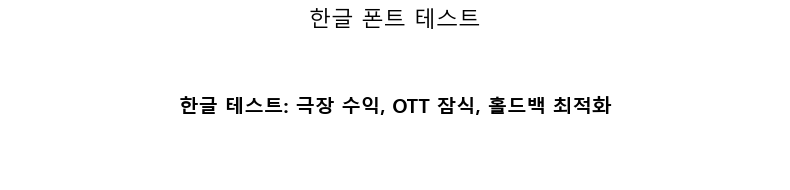

In [203]:
# 시각화 전 한글 폰트 재확인
import matplotlib.pyplot as plt
import platform

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

print("✓ 시각화 한글 폰트 재설정 완료")
print(f"  현재 폰트: {plt.rcParams['font.family']}")

# 폰트 테스트
fig, ax = plt.subplots(figsize=(8, 2))
ax.text(0.5, 0.5, '한글 테스트: 극장 수익, OTT 잠식, 홀드백 최적화', 
        ha='center', va='center', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('한글 폰트 테스트', fontsize=16)
plt.tight_layout()
plt.show()


In [204]:
# 6.2 시각화 함수
print(f"\n[6.2] 시각화 함수 정의...")

def plot_revenue_curves(movie_id, holdback_days=30, horizon=90):
    """
    Rb vs Ra 곡선을 시각화
    
    Parameters:
    - movie_id: 영화 ID
    - holdback_days: 홀드백 기간
    - horizon: 예측 기간
    """
    # 예측 실행
    days, Rb, Ra, movie_info = predict_revenue_curves(
        movie_id, holdback_days, horizon, verbose=False
    )
    
    # 시각화
    plt.figure(figsize=(14, 6))
    
    plt.plot(days, Rb, label='Rb (자연 수익 곡선)', linewidth=2.5, color='blue', alpha=0.8)
    plt.plot(days, Ra, label=f'Ra (홀드백 {holdback_days}일)', linewidth=2.5, color='red', alpha=0.8, linestyle='--')
    plt.axvline(x=holdback_days, color='green', linestyle=':', linewidth=2, label=f'OTT 출시일 (D+{holdback_days})')
    
    # 잠식 영역 표시
    plt.fill_between(days[holdback_days:], Rb[holdback_days:], Ra[holdback_days:], 
                     alpha=0.3, color='red', label='잠식 손실')
    
    plt.xlabel('개봉 후 경과일 (Days)', fontsize=12)
    plt.ylabel('일일 매출액 (KRW)', fontsize=12)
    plt.title(f'영화 "{movie_info["title"]}" ({movie_info["genre"]}) - 수익 곡선 예측', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(alpha=0.3)
    
    # 통계 정보 텍스트 박스
    total_rb = sum(Rb)
    total_ra = sum(Ra)
    loss = total_rb - total_ra
    loss_pct = (loss / total_rb) * 100
    
    textstr = f'TFS: {movie_info["TFS"]:.1f} | ONS: {movie_info["ONS"]:.1f}\n'
    textstr += f'잠식계수: {movie_info["cannibalization_coef"]:.3f}\n'
    textstr += f'총 Rb: {total_rb:,.0f} KRW\n'
    textstr += f'총 Ra: {total_ra:,.0f} KRW\n'
    textstr += f'손실: {loss:,.0f} KRW ({loss_pct:.1f}%)'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

print(f"✓ 시각화 함수 정의 완료")
print(f"  - 함수명: plot_revenue_curves()")

print("\n" + "=" * 60)
print("STEP 6 완료: 통합 파이프라인 구축")
print("=" * 60)



[6.2] 시각화 함수 정의...
✓ 시각화 함수 정의 완료
  - 함수명: plot_revenue_curves()

STEP 6 완료: 통합 파이프라인 구축


In [205]:
# ============================================
# STEP 7: 모델 저장 및 검증
# ============================================

import joblib

print("\n" + "=" * 60)
print("STEP 7: 모델 저장 및 검증 시작")
print("=" * 60)

# 7.1 모델 및 스케일러 저장
print(f"\n[7.1] 모델 및 스케일러 저장...")

# LSTM 모델 저장
model_Rb.save('model_2A_Rb_LSTM.h5')
print(f"✓ LSTM 모델 저장: model_2A_Rb_LSTM.h5")

# Scaler 저장
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print(f"✓ Scaler 저장: scaler_X.pkl, scaler_y.pkl")

# 영화 메타데이터 저장 (잠식 계수 포함)
movie_meta.to_csv('movie_meta_with_cannib.csv', index=False, encoding='utf-8-sig')
print(f"✓ 영화 메타데이터 저장: movie_meta_with_cannib.csv")

print(f"\n저장된 파일 목록:")
print(f"  1. model_2A_Rb_LSTM.h5 - 학습된 LSTM 모델")
print(f"  2. model_Rb_best.h5 - Best checkpoint 모델")
print(f"  3. scaler_X.pkl - 입력 피처 스케일러")
print(f"  4. scaler_y.pkl - 타겟 변수 스케일러")
print(f"  5. movie_meta_with_cannib.csv - 잠식 계수가 포함된 영화 메타데이터")



STEP 7: 모델 저장 및 검증 시작

[7.1] 모델 및 스케일러 저장...
✓ LSTM 모델 저장: model_2A_Rb_LSTM.h5
✓ Scaler 저장: scaler_X.pkl, scaler_y.pkl
✓ 영화 메타데이터 저장: movie_meta_with_cannib.csv

저장된 파일 목록:
  1. model_2A_Rb_LSTM.h5 - 학습된 LSTM 모델
  2. model_Rb_best.h5 - Best checkpoint 모델
  3. scaler_X.pkl - 입력 피처 스케일러
  4. scaler_y.pkl - 타겟 변수 스케일러
  5. movie_meta_with_cannib.csv - 잠식 계수가 포함된 영화 메타데이터



[7.2] 파이프라인 테스트...

테스트 영화 ID: 20190300

테스트 1: 홀드백 30일 시나리오

영화 ID 20190300 수익 곡선 예측 시작

[1] 영화 정보:
  - 제목: 보고타: 마지막 기회의 땅
  - 장르: 범죄 (Thriller)
  - TFS: 4.90
  - ONS: 9.60
  - 잠식 계수: 0.418 (41.8%)

[2] 초기 데이터:
  - 최근 7일 데이터 확보
  - 기간: 2025-01-08 ~ 2025-01-14

[3] Rb 예측 중 (Rolling Prediction for 60일)...


c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: U

  ✓ Rb 예측 완료
  - 예측 기간: D+1 ~ D+60
  - 총 매출 예상: 6,617,156,194 KRW

[4] Ra 시뮬레이션 (홀드백=30일)...
  ✓ Ra 시뮬레이션 완료
  - 총 매출 예상: 5,272,429,655 KRW
  - 잠식 손실: 1,344,726,538 KRW (20.3%)

예측 완료!

✓ 테스트 1 성공!

테스트 2: 시각화 테스트


c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\1029l\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: U

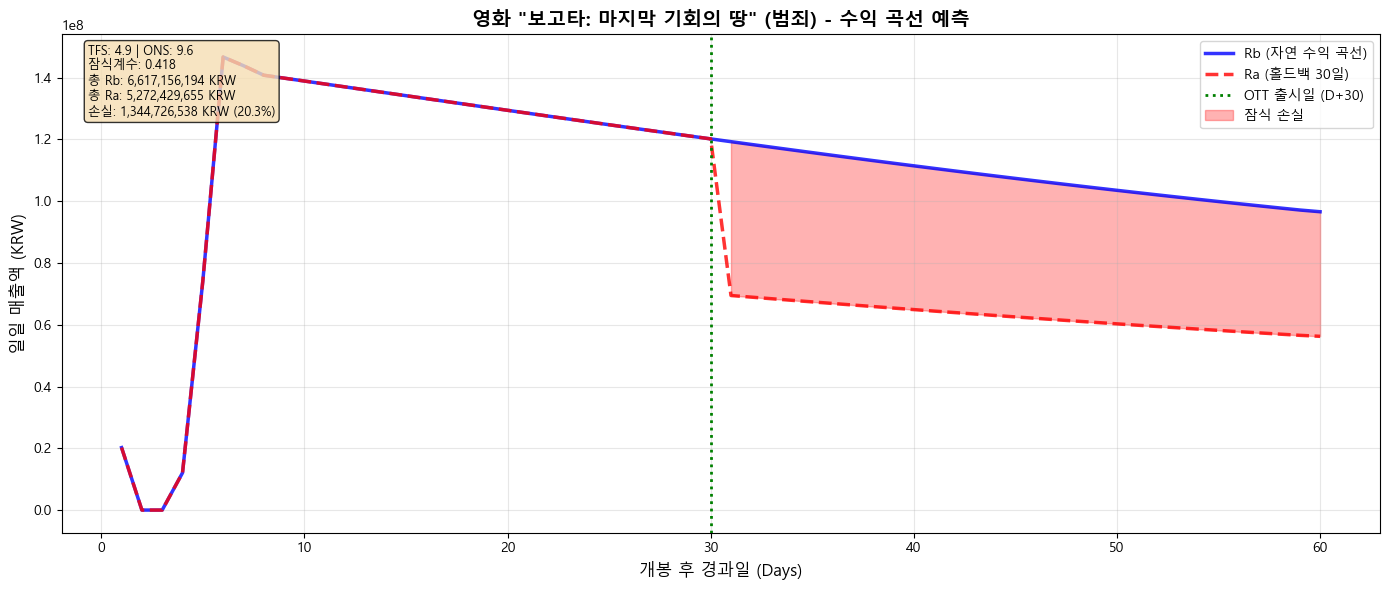


✓ 테스트 2 성공!

STEP 7 완료: 모델 저장 및 검증


In [210]:
# 7.2 파이프라인 테스트 (샘플 영화로 검증)
print(f"\n[7.2] 파이프라인 테스트...")
print("=" * 60)

# 테스트할 영화 ID 선택 (데이터가 충분한 영화 중 랜덤)
test_movie_candidates = performance[performance.groupby('movie_id')['movie_id'].transform('count') >= 10]['movie_id'].unique()

if len(test_movie_candidates) > 0:
    test_movie_id = test_movie_candidates[0]
    
    print(f"\n테스트 영화 ID: {test_movie_id}")
    print(f"\n{'='*50}")
    print("테스트 1: 홀드백 30일 시나리오")
    print(f"{'='*50}")
    
    try:
        days, Rb, Ra, movie_info = predict_revenue_curves(test_movie_id, holdback_days=30, horizon=60, verbose=True)
        print(f"\n✓ 테스트 1 성공!")
    except Exception as e:
        print(f"\n✗ 테스트 1 실패: {e}")
    
    print(f"\n{'='*50}")
    print("테스트 2: 시각화 테스트")
    print(f"{'='*50}")
    
    try:
        plot_revenue_curves(test_movie_id, holdback_days=30, horizon=60)
        print(f"\n✓ 테스트 2 성공!")
    except Exception as e:
        print(f"\n✗ 테스트 2 실패: {e}")
else:
    print("⚠ 테스트 가능한 영화가 없습니다 (10일 이상 데이터 필요)")

print("\n" + "=" * 60)
print("STEP 7 완료: 모델 저장 및 검증")
print("=" * 60)


In [207]:
# ============================================
# 최종 요약 및 사용 가이드
# ============================================

print("\n" + "=" * 70)
print(" " * 20 + "🎉 모델 2 구축 완료! 🎉")
print("=" * 70)

print(f"\n📊 최종 산출물:")
print(f"  ✓ 모델 2-A (Rb 예측 LSTM): {X_train.shape[0]:,}개 샘플로 훈련")
print(f"  ✓ 모델 2-B (Ra 시뮬레이션): Rule-Based 잠식 모델")
print(f"  ✓ 통합 파이프라인: predict_revenue_curves() 함수")
print(f"  ✓ 시각화 함수: plot_revenue_curves() 함수")

print(f"\n🎯 Part 3 시뮬레이션에서 사용하는 방법:")
print(f"""
# 1. 특정 영화의 Rb/Ra 곡선 예측
days, Rb, Ra, movie_info = predict_revenue_curves(
    movie_id='20190300',
    holdback_days=30,
    horizon=180
)

# 2. 시각화
plot_revenue_curves(
    movie_id='20190300',
    holdback_days=30,
    horizon=90
)

# 3. 다양한 홀드백 시나리오 비교
for holdback in [15, 30, 60, 90]:
    days, Rb, Ra, info = predict_revenue_curves('20190300', holdback, 180, verbose=False)
    total_revenue = sum(Ra)
    print(f"홀드백 {{holdback}}일: 총 매출 {{total_revenue:,.0f}} KRW")
""")

print(f"\n📁 저장된 파일:")
print(f"  - model_2A_Rb_LSTM.h5")
print(f"  - scaler_X.pkl, scaler_y.pkl")
print(f"  - movie_meta_with_cannib.csv")

print(f"\n💡 핵심 특징:")
print(f"  1. α 분리: 모델 1과 독립적으로 HHI(CI')로 경쟁 강도 측정")
print(f"  2. Missing Data 해결: Ra는 이론 기반 시뮬레이션으로 생성")
print(f"  3. TFS/ONS 활용: 장르별 적합도 점수로 잠식 계수 개인화")
print(f"  4. Rolling Prediction: 180일 장기 예측 지원")

print(f"\n⚠️  주의사항:")
print(f"  - Rolling Prediction의 오차 누적: 장기 예측 시 불확실성 증가")
print(f"  - 피처 동적 업데이트: 현재는 day_number만 업데이트 (추후 개선 필요)")
print(f"  - 데이터 의존성: 최소 7일 이상의 극장 성과 데이터 필요")

print("\n" + "=" * 70)
print(" " * 15 + "모델 2 구축이 완료되었습니다!")
print(" " * 10 + "Part 3 시뮬레이션에 바로 사용할 수 있습니다.")
print("=" * 70)



                    🎉 모델 2 구축 완료! 🎉

📊 최종 산출물:
  ✓ 모델 2-A (Rb 예측 LSTM): 1,499개 샘플로 훈련
  ✓ 모델 2-B (Ra 시뮬레이션): Rule-Based 잠식 모델
  ✓ 통합 파이프라인: predict_revenue_curves() 함수
  ✓ 시각화 함수: plot_revenue_curves() 함수

🎯 Part 3 시뮬레이션에서 사용하는 방법:

# 1. 특정 영화의 Rb/Ra 곡선 예측
days, Rb, Ra, movie_info = predict_revenue_curves(
    movie_id='20190300',
    holdback_days=30,
    horizon=180
)

# 2. 시각화
plot_revenue_curves(
    movie_id='20190300',
    holdback_days=30,
    horizon=90
)

# 3. 다양한 홀드백 시나리오 비교
for holdback in [15, 30, 60, 90]:
    days, Rb, Ra, info = predict_revenue_curves('20190300', holdback, 180, verbose=False)
    total_revenue = sum(Ra)
    print(f"홀드백 {holdback}일: 총 매출 {total_revenue:,.0f} KRW")


📁 저장된 파일:
  - model_2A_Rb_LSTM.h5
  - scaler_X.pkl, scaler_y.pkl
  - movie_meta_with_cannib.csv

💡 핵심 특징:
  1. α 분리: 모델 1과 독립적으로 HHI(CI')로 경쟁 강도 측정
  2. Missing Data 해결: Ra는 이론 기반 시뮬레이션으로 생성
  3. TFS/ONS 활용: 장르별 적합도 점수로 잠식 계수 개인화
  4. Rolling Prediction: 180일 장기 예측 지원

⚠️  주의사항:
  - Rolling Pr

# 📝 사용 예제 (Usage Examples)

아래 셀을 실행하여 모델을 테스트해보세요!

## 예제 1: 특정 영화의 수익 곡선 예측

```python
# 영화 ID를 지정하고 예측 실행
movie_id = '20190300'  # 원하는 영화 ID로 변경
holdback_days = 30     # 홀드백 기간 (일)
horizon = 90           # 예측 기간 (일)

days, Rb, Ra, movie_info = predict_revenue_curves(movie_id, holdback_days, horizon)
```

## 예제 2: 시각화

```python
plot_revenue_curves(movie_id='20190300', holdback_days=30, horizon=90)
```

## 예제 3: 다양한 홀드백 시나리오 비교

```python
movie_id = '20190300'
scenarios = [15, 30, 60, 90, 120]

print(f"{'홀드백 (일)':<15} {'총 매출 (KRW)':<20} {'손실 (%)':<10}")
print("=" * 50)

for holdback in scenarios:
    days, Rb, Ra, info = predict_revenue_curves(movie_id, holdback, 180, verbose=False)
    total_rb = sum(Rb)
    total_ra = sum(Ra)
    loss_pct = ((total_rb - total_ra) / total_rb) * 100
    
    print(f"{holdback:<15} {total_ra:>18,.0f} {loss_pct:>9.1f}%")
```

## 예제 4: 장르별 비교

```python
# 장르별 대표 영화 선택 및 비교
genre_examples = {
    '액션': movie_meta[movie_meta['genre'] == '액션']['movieCd'].iloc[0] if len(movie_meta[movie_meta['genre'] == '액션']) > 0 else None,
    '드라마': movie_meta[movie_meta['genre'] == '드라마']['movieCd'].iloc[0] if len(movie_meta[movie_meta['genre'] == '드라마']) > 0 else None,
}

for genre, movie_id in genre_examples.items():
    if movie_id and str(movie_id) in performance['movie_id'].values:
        try:
            plot_revenue_curves(str(movie_id), holdback_days=30, horizon=60)
        except:
            print(f"{genre} 영화 예측 실패")
```


In [208]:
# 예제 실행 셀 (필요시 주석 해제하여 실행)

# 사용 가능한 영화 목록 확인
print("데이터가 충분한 영화 목록 (10일 이상):")
print("=" * 60)

sufficient_movies = performance.groupby('movie_id').size()
sufficient_movies = sufficient_movies[sufficient_movies >= 10].sort_values(ascending=False)

for i, (movie_id, count) in enumerate(sufficient_movies.head(10).items(), 1):
    movie_name = movie_meta[movie_meta['movieCd'] == movie_id]['title'].values
    movie_name = movie_name[0] if len(movie_name) > 0 else 'N/A'
    genre = movie_meta[movie_meta['movieCd'] == movie_id]['genre'].values
    genre = genre[0] if len(genre) > 0 else 'N/A'
    print(f"{i:2d}. ID: {movie_id} | {movie_name:30s} | {genre:10s} | {count:3d}일")

print(f"\n총 {len(sufficient_movies)}개 영화 사용 가능")
print("\n위 영화 ID를 사용하여 아래 예제를 실행해보세요!")
print("예: plot_revenue_curves('20190300', holdback_days=30, horizon=90)")


데이터가 충분한 영화 목록 (10일 이상):
 1. ID: 20234675 | 파묘                             | 공포         |  83일
 2. ID: 20212866 | 서울의 봄                          | 드라마        |  81일
 3. ID: 20228797 | 범죄도시4                          | 범죄         |  63일
 4. ID: 20226411 | 범죄도시3                          | 범죄         |  54일
 5. ID: 20200142 | 소방관                            | 드라마        |  53일
 6. ID: 20249733 | 사랑의 하츄핑                        | 애니메이션      |  53일
 7. ID: 20228819 | 30일                            | 코미디        |  53일
 8. ID: 20218541 | 밀수                             | 액션         |  51일
 9. ID: 20224666 | 파일럿                            | 코미디        |  50일
10. ID: 20228796 | 하얼빈                            | 드라마        |  50일

총 61개 영화 사용 가능

위 영화 ID를 사용하여 아래 예제를 실행해보세요!
예: plot_revenue_curves('20190300', holdback_days=30, horizon=90)


In [209]:
# 🧪 자유 테스트 셀 (여기서 자유롭게 예제를 실행해보세요!)

# 예제: 특정 영화의 수익 곡선 시각화
# plot_revenue_curves('20190300', holdback_days=30, horizon=90)

# 예제: 여러 홀드백 시나리오 비교
# for holdback in [15, 30, 60, 90]:
#     days, Rb, Ra, info = predict_revenue_curves('20190300', holdback, 180, verbose=False)
#     print(f"홀드백 {holdback}일: 총 매출 {sum(Ra):,.0f} KRW")

